# **WorldPop versus DHIS2 population comparison analysis**


In [1]:
# system("conda install -c conda-forge libgdal-hdf5 -y")

In [2]:
# Set SNT Paths
# Set SNT Paths
SNT_ROOT_PATH  <- "~/workspace"
CODE_PATH      <- file.path(SNT_ROOT_PATH, "code")
CONFIG_PATH    <- file.path(SNT_ROOT_PATH, "configuration")
 
# load util functions
source(file.path(CODE_PATH, "snt_utils.r"))

# List required packages 
required_packages <- c("tidyr", "terra", "arrow", "sf", "dplyr", "ggplot2") 

# Execute function
install_and_load(required_packages)

Warning message:
“package ‘terra’ was built under R version 4.4.3”
Warning message:
“package ‘sf’ was built under R version 4.4.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”


          tidyr           terra           arrow              sf           dplyr 
  "tidyr 1.3.1"  "terra 1.8.42"  "arrow 18.1.0"     "sf 1.0.20"   "dplyr 1.1.4" 
        ggplot2 
"ggplot2 3.5.2" 


In [3]:
# Set variables to load openhexa.sdk from the right environment
Sys.setenv(PROJ_LIB = "/opt/conda/share/proj")
Sys.setenv(GDAL_DATA = "/opt/conda/share/gdal")
Sys.setenv(RETICULATE_PYTHON = "/opt/conda/bin/python")

In [4]:
# 1. Load data
# dhis2_pop <- read_parquet(file.path(SNT_ROOT_PATH, "data/dhis2_formatted/COD_population.parquet"))
dhis2_pop <- read_parquet(file.path(SNT_ROOT_PATH, "pipelines/snt_worldpop_extract/dev/dhis2_pop_2020.parquet"))
dhis2_shapes <- st_read(file.path(SNT_ROOT_PATH, "data/dhis2/formatted/COD_shapes.geojson"))
wp_raster <- rast(file.path(SNT_ROOT_PATH, "data/worldpop/raw/population/COD_wpop_population_2020_compressed.tif"))

Reading layer `/home/hexa/workspace/data/dhis2_formatted/COD_shapes.geojson' from data source `/home/jovyan/workspace/data/dhis2/formatted/COD_shapes.geojson' 
  using driver `GeoJSON'
Simple feature collection with 519 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 12.19965 ymin: -13.456 xmax: 31.27724 ymax: 5.378271
Geodetic CRS:  WGS 84


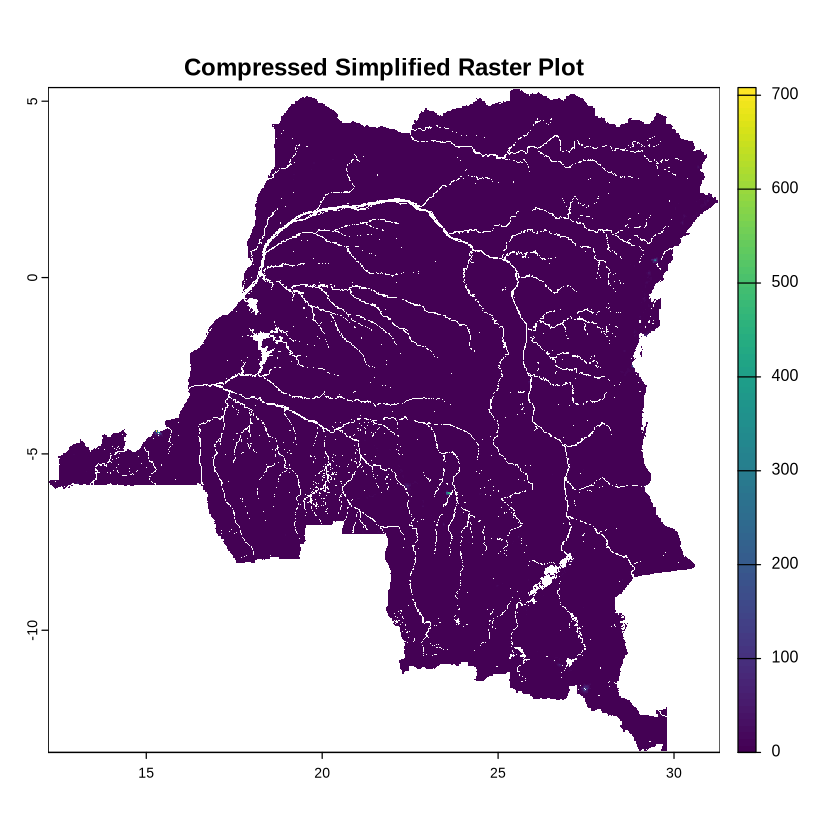

In [5]:
# Plot the simplified version
r_comp_simplified <- aggregate(wp_raster, fact = 20, fun = "mean")
plot(r_comp_simplified, main = "Compressed Simplified Raster Plot")

## Zone de sante comparison

In [6]:
# to numeric values
dhis2_pop$value <- as.numeric(dhis2_pop$value)

# 2. Summarize WorldPop per adm2 polygon
shapes_vect <- vect(dhis2_shapes)
wp_pop_extract <- extract(wp_raster, shapes_vect, fun = sum, na.rm = TRUE) 
dhis2_shapes$worldpop_population <- wp_pop_extract[, 2]

In [7]:
write.csv(dhis2_shapes, file = file.path(SNT_ROOT_PATH, 'pipelines/snt_worldpop_extract/reporting/data/wp_pop_adm2.csv'))

In [8]:
# 3. Compare WorldPop vs DHIS2 (if you have a matching ID column)
comparison_df <- left_join(dhis2_shapes, dhis2_pop, by = c("ADM2_ID" = "ou"))

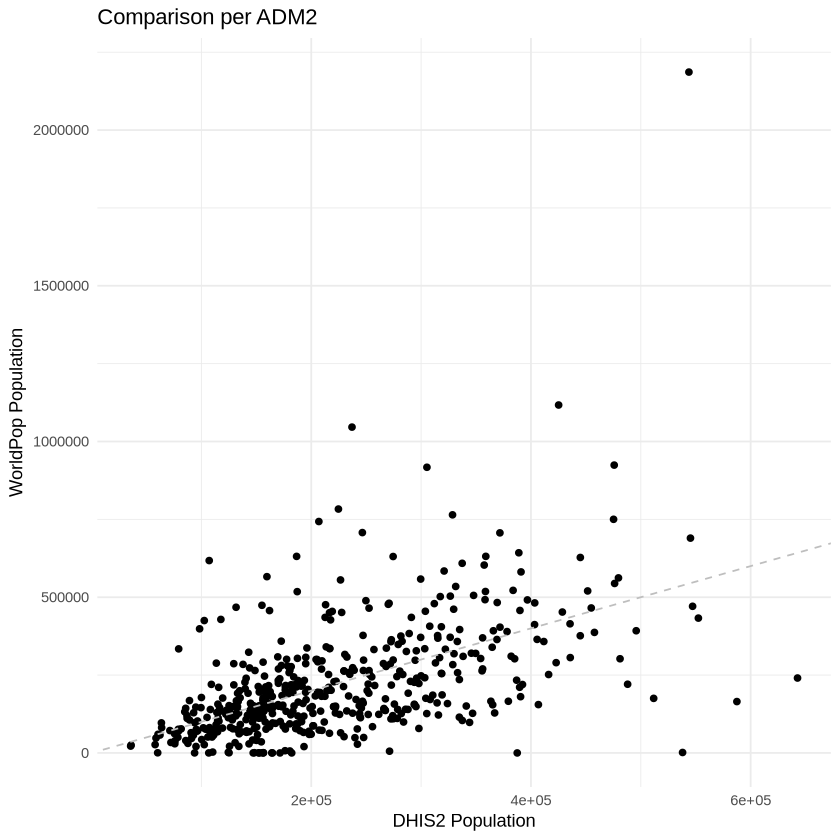

In [9]:
ggplot(comparison_df, aes(x = value, y = worldpop_population)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  labs(x = "DHIS2 Population", y = "WorldPop Population", 
       title = "Comparison per ADM2") +
  theme_minimal()

In [10]:
pop_correlation <- cor(comparison_df$value, comparison_df$worldpop_population, method = 'pearson')
round(pop_correlation, 2)

[1] 0.54

In [11]:
sapply(
    setNames(
        list(comparison_df$value, comparison_df$worldpop_population),
        c("DHIS2_population", "WPOP_population")
    ),
    summary
)

,DHIS2_population,WPOP_population
Min.,35615.0,0.0
1st Qu.,144090.0,100580.9
Median,193000.0,166000.9
Mean,218943.2,219145.9
3rd Qu.,282320.5,289476.0
Max.,642675.0,2186235.9


The above table shows that some of the values of WPOP tend to be less plausible, with some Zones de Santé (ZS) having 0 inhabitants, while the largest ZS, which is likely one of the districts of Kinshasa, appears with nearly 22 million inhabitants, thus more than the total population of Kinshasa (17 million). 

In [12]:
comp.pop <- comparison_df %>%
  select(ADM2, worldpop_population, value) %>%
  mutate(
      diff = worldpop_population - value,
      ratio = worldpop_population / value,
      relative_diff = diff / value
  )

In [13]:
hist_pop <- st_drop_geometry(comp.pop) %>%
    select(ADM2, worldpop_population, value) %>%
    rename(
        WPOP = worldpop_population,
        DHIS2 = value
    ) %>%
    pivot_longer(
    cols = c(WPOP, DHIS2),
    names_to = "source",
    values_to = "population"
  )

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


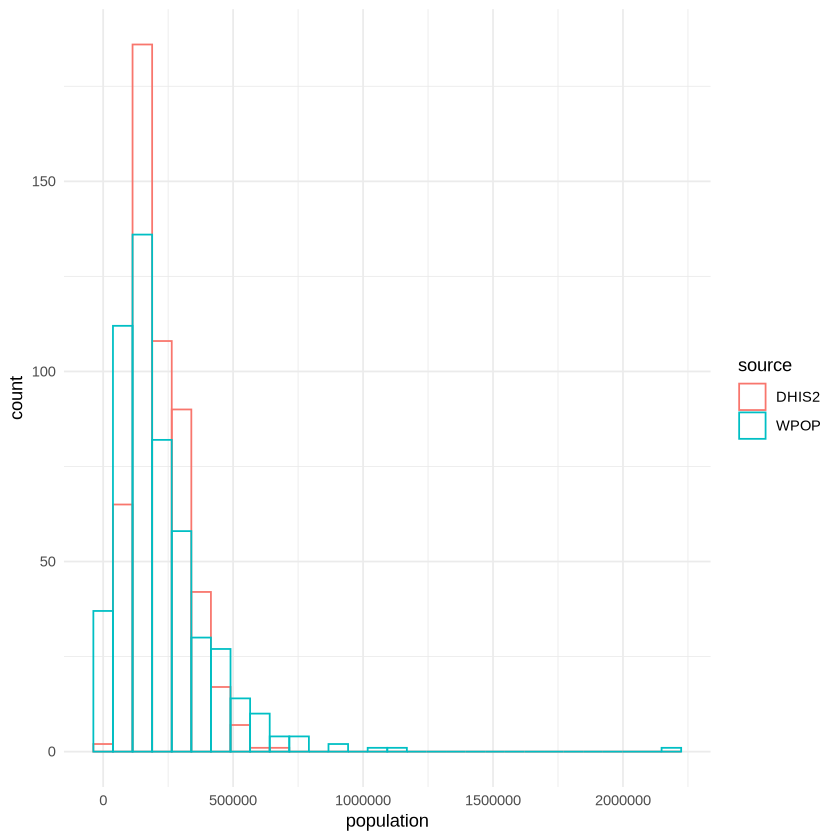

In [14]:
ggplot(hist_pop, aes(x=population, color=source)) +
  geom_histogram(fill=NA, alpha=0.7, position="identity") + theme_minimal()

WorldPop data appears to have more variability and some extreme outliers to the right.

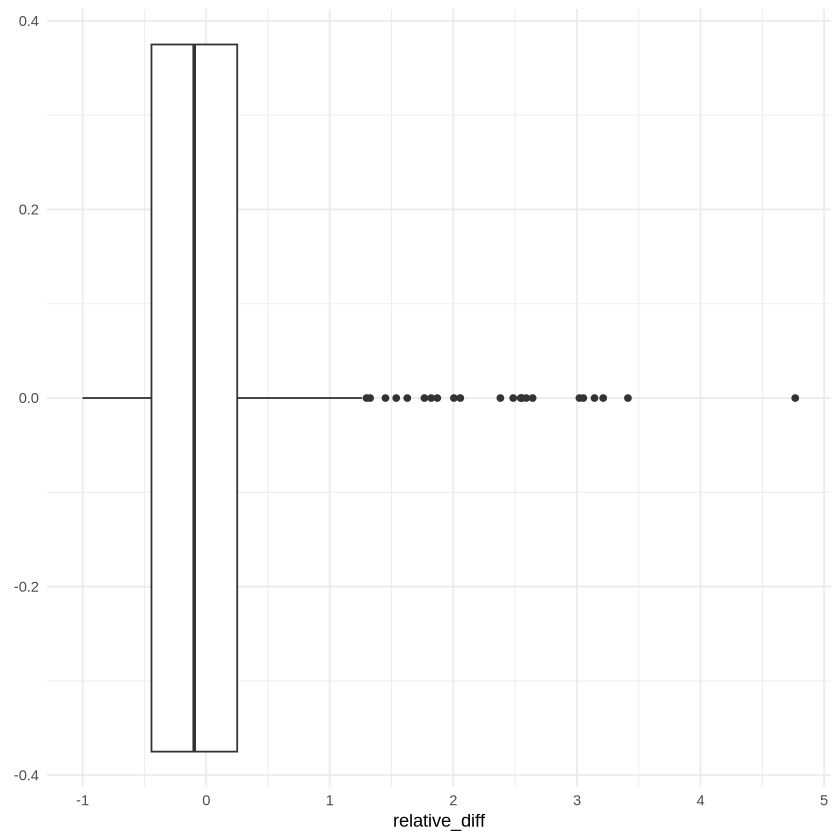

In [15]:
ggplot(comp.pop, aes(y=relative_diff)) + 
  geom_boxplot() + coord_flip() + theme_minimal()

The above plot shows that for 75% of Zones de Santé (ZS), the difference between DHIS2 and WorldPop data is within 50% of the total DHIS2, which indicates significant deviation between the two sources. Most of the remaining ZS (except the outliers represented as dots) have differences of population that are 0.5-1.5 of the total DHIS2 population.

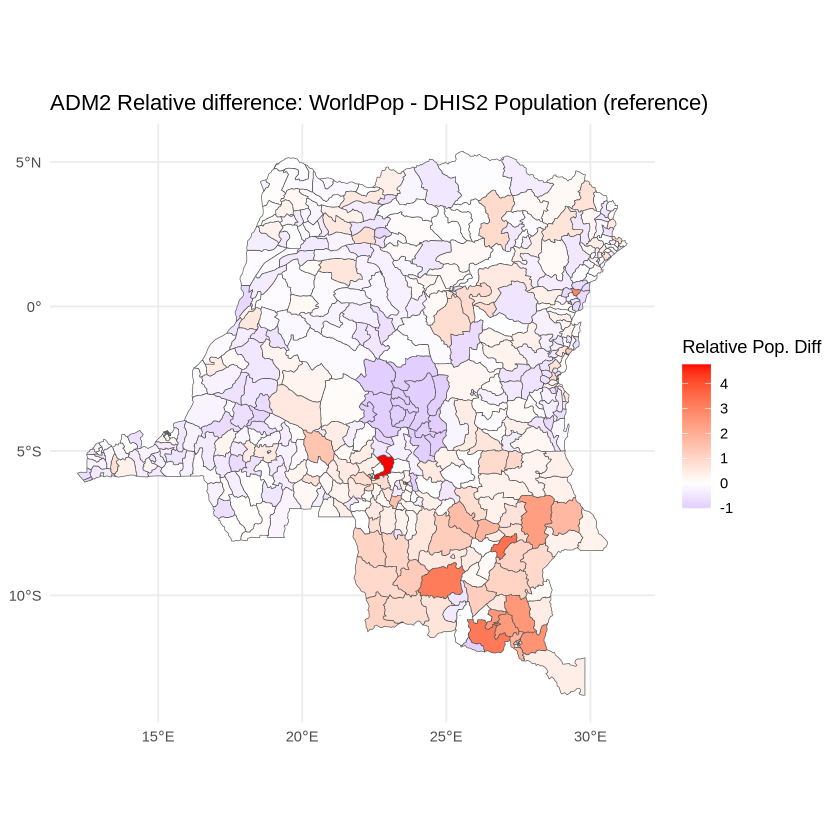

In [16]:
ggplot(comparison_df) +
  geom_sf(aes(fill = (worldpop_population - value)/value)) +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  labs(title = "ADM2 Relative difference: WorldPop - DHIS2 Population (reference)",
       fill = "Relative Pop. Diff") +
  theme_minimal()

## Province comparison

In [17]:
# Group by province (ADM1) and dissolve geometries
dhis2_shapes_provinces <- dhis2_shapes %>%
  group_by(ADM1_ID) %>%
  summarise(geometry = st_union(geometry), .groups = "drop")

In [18]:
# to numeric values
dhis2_pop$value <- as.integer(dhis2_pop$value)

In [19]:
# 2. Summarize WorldPop per adm2 polygon
shapes_vect_province <- vect(dhis2_shapes_provinces)
wp_pop_extract_province <- extract(wp_raster, shapes_vect_province, fun = sum, na.rm = TRUE)

In [20]:
dhis2_shapes_provinces$worldpop_population_prov <- wp_pop_extract_province[, 2]

In [ ]:
write.csv(dhis2_shapes_provinces, file = file.path(SNT_ROOT_PATH, 'pipelines/snt_worldpop_extract/reporting/data/wp_pop_adm1.csv')) 

In [ ]:
# Group pop by provinces
dhis2_pop_prov <- dhis2_pop %>%
  group_by(level_2_id, level_2_name) %>%
  summarise(total_value = sum(value, na.rm = TRUE))

In [ ]:
comparison_df_prov <- left_join(dhis2_shapes_provinces, dhis2_pop_prov, by = c("ADM1_ID" = "level_2_id"))

In [ ]:
ggplot(comparison_df_prov, aes(x = total_value, y = worldpop_population_prov)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  labs(x = "DHIS2 Population", y = "WorldPop Population", 
       title = "Comparison per ADM2") +
  theme_minimal()

In [ ]:
ggplot(comparison_df_prov) +
  geom_sf(aes(fill = worldpop_population_prov - total_value)) +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  labs(title = "Difference: WorldPop - DHIS2 Population (ADM2)",
       fill = "Pop. Diff") +
  theme_minimal()